<a href="https://colab.research.google.com/github/hechen2020/19ma573HuixinChen/blob/master/src/hw_vasicek_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##hw_vasicek_calibration
###goal: to design pricing engine and calibrate vasicek model from data

##Verify:

$$r_t=r_0e^{-\kappa t}+\mu(1-e^{-\kappa t})+\sigma^{-\kappa t}\int_0^t{e^{\kappa t}dW_s}$$

is the solution for

$$dr_t=\kappa(\mu-r_t)dt+\sigma dW_t$$

with $r_0$

##Steps:

We can first distribute the terms and isolate the terms with $dr_t$ and $r_t$ in the differential equation and get:

$$dr_t+\kappa r_tdt=\kappa\mu+\sigma dW_t$$

Then multiply both sides by the integrating factor $e^{\kappa t}$ and get

$$e^{\kappa t}dr_t+e^{\kappa t}\kappa r_tdt=e^{\kappa t}\kappa\mu+e^{\kappa t}\sigma dW_t$$

note on the left side, if we let $x=r_t$ and $y=e^{\kappa t}$, we should have

$$\frac{dx}{dt} = dr_t = x'$$

$$\frac{dy}{dt} = \kappa e^{\kappa t}dt = y'$$

so the left-hand side becomes

$$x'y+y'x$$

which is equal to $(xy)'$ by property of derivative. So the original differential equation becomes

$$d(e^{\kappa t}r_t) = e^{\kappa t}\kappa\mu+e^{\kappa t}\sigma dW_t$$

We can then integrate both sides to get

$$\int_0^t{d(e^{\kappa s}r_s)}ds = \int_0^t{e^{\kappa s}\kappa\mu+e^{\kappa s}\sigma dW_s}ds$$

where the left-hand side becomes

$$\int_0^t{d(e^{\kappa s}r_s)}ds = e^{\kappa t}r_t - e^0r_0 = e^{\kappa t}r_t - r_0$$

so have

$$e^{\kappa t}r_t - r_0 = \int_0^t{e^{\kappa s}\kappa\mu+e^{\kappa s}\sigma dW_s}ds = \int_0^t{e^{\kappa s}\kappa\mu}ds+\int_0^t{e^{\kappa s}\sigma dW_s}ds$$

On the right-hand side, the first term can be simply integrated as

$$\int_0^t{e^{\kappa s}\kappa\mu}ds = \mu(e^{\kappa t}-1)$$

and in the second term the term $\sigma$ can be pulled out. So we obtain

$$e^{\kappa t}r_t - r_0=\mu(e^{\kappa t}-1)+\sigma\int_0^t{e^{\kappa s}dW_s}ds$$

so

$$r_t = e^{-\kappa t}r_0+e^{-\kappa t}\mu(e^{\kappa t}-1)+e^{-\kappa t}\sigma\int_0^t{e^{\kappa s}dW_s}ds$$

$$r_t = e^{-\kappa t}r_0+\mu(1-e^{-\kappa t})+\sigma e^{-\kappa t}\int_0^t{e^{\kappa s}dW_s}ds$$


###Design pricing engine of ZCB using explicit formula

In [0]:
import numpy as np
import array
import scipy.optimize as so
import matplotlib.pyplot as plt

In [0]:
def zcb_pricing(r0, T, kappa, mu, sigma):
  b = (1-np.exp(-kappa*T))/kappa
  a = (mu - sigma**2/(2*(kappa**2)))*(b-T)-(sigma**2/(4*kappa))*(b**2)
  price = np.exp(a-b*r0)
  
  return price

###Design pricing engine using exact sampling

In [0]:
def zcb_pricing_es(r0, T, kappa, mu, sigma, n):
  
  arr_price = array.array('f',[])
  for i in range(n):
    Z = np.random.normal()
    R = (mu*T + (r0-mu)*((1-np.exp(-kappa*T))/kappa)) + Z*np.sqrt((sigma**2/(2*kappa**3))*(2*kappa*T-3+4*np.exp(-kappa*T)-np.exp(-2*kappa*T)))
    p = np.exp(-R)
    arr_price.append(p)

  return np.mean(arr_price)
  

In [0]:
def zcb_libor(price, T):
  lrate = (100/T)*((1/price)-1)
  
  return lrate

In [5]:
theta = [.1, .05, .003, .03]
kappa, mu, sigma, r0 = theta

T = 1

#using explicit formula
zcb_p1 = zcb_pricing(r0, T, kappa, mu, sigma)
zcb_l1 = zcb_libor(zcb_p1, T)

#using exact sampling with 100 samples
zcb_p2 = zcb_pricing_es(r0, T, kappa, mu, sigma, 100)
zcb_l2 = zcb_libor(zcb_p2, T)

print(zcb_p1)
print(zcb_l1)

print(zcb_p2)
print(zcb_l2)

0.9695084475425054
3.145052787810565
0.9697322
3.1212508237085768


### Find 10 term swap rates

$$s(t, T, N)=100\frac{1-P(t,T)}{\Delta\sum_{j=1}^N{P(t,t+j\Delta)}}$$

$$\Delta=\frac{T-t}{N}$$

In [0]:
def term_swap(r0, T, kappa, mu, sigma, N):
  delta = T/N
  
  arr_p = array.array('f',[])
  for i in range(N):
    p = zcb_pricing(r0, (i+1)*delta, kappa, mu, sigma)
    arr_p.append(p)
    
  swap = 100*((1-zcb_pricing(r0, T, kappa, mu, sigma))/(delta*sum(arr_p)))
    
  return swap

In [0]:
def term_swap_es(r0, T, kappa, mu, sigma, N, num_path):
  delta = T/N
  
  arr_p = array.array('f',[])
  for i in range(N):
    p = zcb_pricing_es(r0, (i+1)*delta, kappa, mu, sigma, num_path)
    arr_p.append(p)
    
  swap = 100*((1-zcb_pricing_es(r0, T, kappa, mu, sigma, num_path))/(delta*sum(arr_p)))
    
  return swap

In [54]:
T = 5
N = 10
swap_rate = term_swap(r0, T, kappa, mu, sigma, N)
swap_rate_es = term_swap_es(r0, T, kappa, mu, sigma, N, 100)
print(swap_rate)
print(swap_rate_es)

3.441821404372335
3.460067613013911


###Callibrate Vasicek model using Libor market data, then compare

In [0]:
import pandas as pd
dfLiborRate = pd.DataFrame({'maturity (months)': [1, 2, 3, 6, 12],
'20081029 rate(%)': [3.1175, 3.2738, 3.4200, 3.4275, 3.4213],
'20110214 rate(%)': [0.2647, 0.2890, 0.3140, 0.4657, 0.7975]
})

In [0]:
libor_20081029 = [3.1175, 3.2738, 3.4200, 3.4275, 3.4213]
libor_maturities = [1/12, 2/12, 3/12, 6/12, 1.]

In [0]:
#Using SSRE and explicit formula
def error_fcn(theta, market_rates, maturities):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_price = zcb_pricing(r0, maturities[i], kappa, mu, sigma)
    cal_rate = zcb_libor(cal_price, maturities[i])
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sqrt(np.sum(arr_e))

#Using SSRE and es
def error_fcn_es(theta, market_rates, maturities, num_path):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_price = zcb_pricing_es(r0, maturities[i], kappa, mu, sigma, num_path)
    cal_rate = zcb_libor(cal_price, maturities[i])
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sqrt(np.sum(arr_e))


In [0]:
#Calibration using explicit formula
def lcalibration(libor_rates, maturities):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn, init_theta,
                 args = (libor_rates, maturities), disp = 0)

#Calibration using es
def lcalibration_es(libor_rates, maturities, num_path):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn_es, init_theta, args = (libor_rates, maturities, num_path), disp = 0)

In [59]:
test = error_fcn(theta, libor_20081029,libor_maturities)
print(test)
test2 = error_fcn_es(theta, libor_20081029, libor_maturities, 100)
print(test2)

#calibrated theta using explicit formula
cal_theta = lcalibration(libor_20081029,libor_maturities)
print(cal_theta)
#calibrated theta using es
cal_theta_es = lcalibration_es(libor_20081029,libor_maturities, 100)
print(cal_theta_es)

0.19182101
0.18907772
[ 5.59152639e+02  3.45052451e-02 -8.14831348e+00 -1.13040283e-01]
[0.10843745 0.04953114 0.00284062 0.03253125]


0.16134936


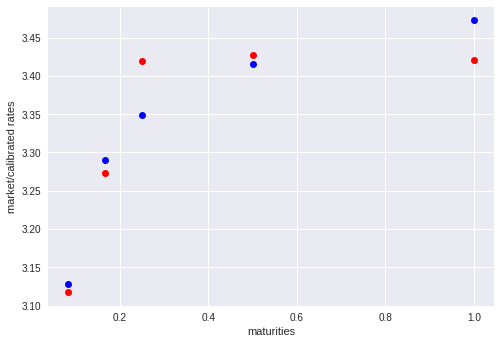

In [60]:
ckappa, cmu, csigma, cr0 = cal_theta

#explicit formula calibration comparison
clibor = array.array('f',[])
clibor_err = array.array('f',[])

for i in range(len(libor_20081029)):
  cprice = zcb_pricing(cr0, libor_maturities[i], ckappa, cmu, csigma)
  cl = zcb_libor(cprice, libor_maturities[i])
  err = np.abs(cl - libor_20081029[i])
  clibor.append(cl)
  clibor_err.append(err)
  
plt.plot(libor_maturities, libor_20081029, 'ro')
plt.plot(libor_maturities, clibor, 'bo')
plt.xlabel('maturities')
plt.ylabel('market/calibrated rates')

print(np.sum(clibor_err))

1.4402524


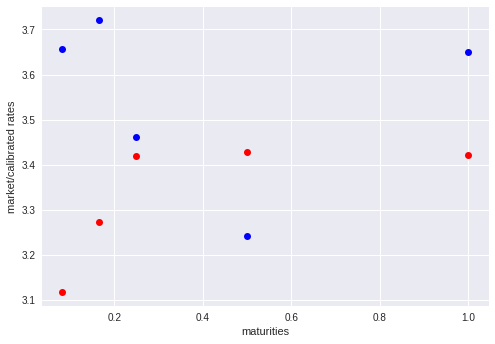

In [61]:
#es calibration comparison: with 100 paths
clibor_es = array.array('f',[])
clibor_err_es = array.array('f',[])

for i in range(len(libor_20081029)):
  cprice = zcb_pricing_es(cr0, libor_maturities[i], ckappa, cmu, csigma, 100)
  cl = zcb_libor(cprice, libor_maturities[i])
  err = np.abs(cl - libor_20081029[i])
  clibor_es.append(cl)
  clibor_err_es.append(err)
  
  
plt.plot(libor_maturities, libor_20081029, 'ro')
plt.plot(libor_maturities, clibor_es, 'bo')
plt.xlabel('maturities')
plt.ylabel('market/calibrated rates')

print(np.sum(clibor_err_es))

explicit formula produces parameters that produce calibrated rates closer to the market rate (and less computational time), but involve negative parameters (drawback)

...

###Callibrate Vasicek model using swap market data, then compare

In [0]:
dfSwapRate = pd.DataFrame({'term (year)': [2, 3, 5, 7, 10, 15, 30],
'20081029 rate(%)': [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772],
'20110214 rate(%)': [1.0481, 1.5577, 2.5569, 3.1850, 3.7225, 4.1683, 4.4407]
})

In [0]:
swap_20081029 = [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772]
swap_maturity = [2, 3, 5, 7, 10, 15, 30]
#assuming as before the term length is 1/2 year
swap_term = [4, 6, 10, 14, 20, 30, 60]

In [0]:
#Using SSRE and explicit formula
def error_fcn_swap(theta, market_rates, maturities, terms):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_rate = term_swap(r0, maturities[i], kappa, mu, sigma, terms[i])
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sum(arr_e)

#Using SSRE and es
def error_fcn_swap_es(theta, market_rates, maturities, terms, num_path):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_rate = term_swap_es(r0, maturities[i], kappa, mu, sigma, terms[i], num_path)
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sum(arr_e)

In [0]:
#Calibration using explicit formula
def scalibration(swap_rates, maturities, terms):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn_swap, init_theta,
                 args = (swap_rates, maturities, terms), disp = 0)

#Calibration using es
def scalibration_es(libor_rates, maturities, terms, num_path):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn_swap_es, init_theta, args = (libor_rates, maturities, terms, num_path), disp = 0)

In [66]:
#calibrated theta using explicit formula
cal_theta_s = scalibration(swap_20081029,swap_maturity, swap_term)
print(cal_theta_s)
#calibrated theta using es
cal_theta_s_es = scalibration_es(swap_20081029,swap_maturity, swap_term, 100)
print(cal_theta_s_es)

[ 1.18531696  0.04717442 -0.02526716 -0.00588583]
[0.10207574 0.05518998 0.00301193 0.02849938]


0.63494384


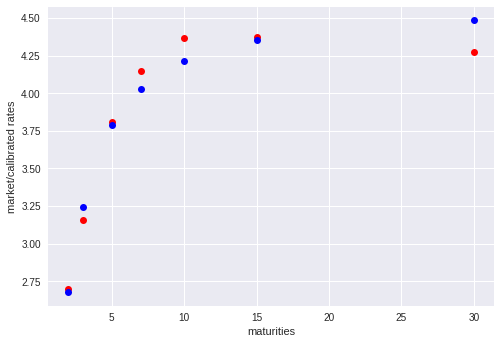

In [67]:
cskappa, csmu, cssigma, csr0 = cal_theta_s

#explicit formula calibration comparison
cswap = array.array('f',[])
cswap_err = array.array('f',[])

for i in range(len(swap_20081029)):
  cs = term_swap(csr0, swap_maturity[i], cskappa, csmu, cssigma, swap_term[i])
  err = np.abs(cs - swap_20081029[i])
  cswap.append(cs)
  cswap_err.append(err)
  
plt.plot(swap_maturity, swap_20081029, 'ro')
plt.plot(swap_maturity, cswap, 'bo')
plt.xlabel('maturities')
plt.ylabel('market/calibrated rates')

print(np.sum(cswap_err))

0.5446303


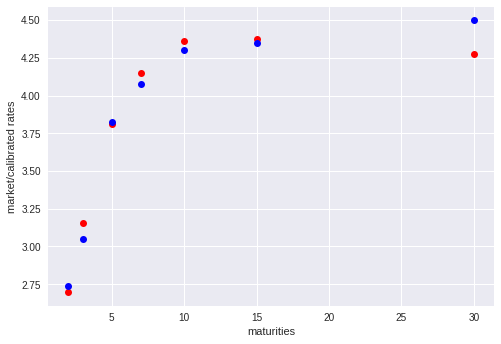

In [68]:
#es calibration comparison: with 100 paths
cswap_es = array.array('f',[])
cswap_err_es = array.array('f',[])

for i in range(len(swap_20081029)):
#  cprice = zcb_pricing_es(cr0, libor_maturities[i], ckappa, cmu, csigma, 100)
  cs = term_swap_es(csr0, swap_maturity[i], cskappa, csmu, cssigma, swap_term[i], 100)
  err = np.abs(cs - swap_20081029[i])
  cswap_es.append(cs)
  cswap_err_es.append(err)
  
plt.plot(swap_maturity, swap_20081029, 'ro')
plt.plot(swap_maturity, cswap_es, 'bo')
plt.xlabel('maturities')
plt.ylabel('market/calibrated rates')

print(np.sum(cswap_err_es))

the es method produces better estimated parameters and calibration for swap rates